In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp

from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", False)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'gpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
import hypar as hp
from scipy.optimize import fsolve

0.4.14
3.11.6
1.11.3


In [12]:
def f(n):
    n_col =n
    n_row = n_col
    x_span = 2.5
    y_span = 10

    # Nodal coordinates
    xs = np.linspace(0,x_span,n_col+1)
    xs = np.tile(xs,n_row+1)
    ys = np.linspace(0,y_span,n_row+1)
    ys = np.tile(ys,(n_col+1,1))
    ys = ys.T.reshape(-1)
    zs =  0.5*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)
    zs = np.tile(zs,n_row+1)
    '''zs = np.where(xs==0,0,zs)
    zs = np.where(xs==x_span,0,zs)
    zs = np.where(ys==0,0,zs)
    zs = np.where(ys==y_span,0,zs)
    '''

    # Connectivity
    n_node = (n_col+1)*(n_row+1)
    n_ele = n_col * n_row
    cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
    for i in range(n_ele):
        i_row = i//n_col
        i_col = (i-i_row*n_col)%n_col
        cnct[i,3] = i + i_row*1 + n_col + 1
        cnct[i,2] = cnct[i,3]+1 
        cnct[i,1] = cnct[i,2] - (n_col + 1)
        cnct[i,0] = cnct[i,1] - 1

    #Properties, design nodes, load
    t = 0.25
    E = 24855578.*1e-6
    nu = 0.2
    design_nodes = []
    non_design_nodes = []
    for i in range(n_node):
        if [xs[i],ys[i]]!= [0,0] and [xs[i],ys[i]] != [0,y_span] and [xs[i],ys[i]] != [x_span,y_span] and [xs[i],ys[i]] != [x_span,0]:
            design_nodes.append(i)
        else:
            non_design_nodes.append(i)
    design_nodes = np.asarray(design_nodes)
    non_design_nodes = np.asarray(non_design_nodes)
    Q = 500*400/((n_row-1)*n_col)
    col = n_col+1
    row = n_row+1
    '''fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    X = xs.reshape((row,col))
    Y = ys.reshape((row,col))
    Z = zs.reshape((row,col))
    ax.set_xlabel('X (m)',fontsize=18)
    ax.set_ylabel('Y (m)',fontsize=18)
    ax.set_zlabel('Z (m)',fontsize=18)
    plt.yticks([0,5,10,15,20],fontsize=14)
    plt.xticks([0,5,10,15,20],fontsize=14)

    ax.set_zlim(-0.5, 10)
    ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
    load_id= np.intersect1d(np.where(xs==0.5*(np.max(xs)+np.min(xs)))[0],np.where(ys== 0.5*(np.max(ys)+np.min(ys)))[0])[0]
    ax.scatter(xs[load_id],ys[load_id],zs[load_id]+0.2,color='blue',label='Loading node',s=20)
    ax.view_init(10, -45)
    plt.legend(loc=(0.6,0.6),fontsize=14)'''
    #%%
    #Create model
    model = Model.Model() #model for sensitivity analysis

    #Adding nodes and boundary conditions
    for i in range(n_node):
        model.add_node(i,xs[i],ys[i],zs[i])
        if i not in design_nodes:
            if ys[i]==0:
                if xs[i]==0 or xs[i]==x_span:
                    model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
                else:
                    model.add_support(i,[1,1,1,0,0,0])
            else:
                model.add_support(i,[1,1,1,0,0,0])
        else:
            model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

    #Adding elements
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        model.add_quad(i,inode, jnode, mnode, nnode, 
                    t, E, nu)

    model.model_ready()
    
    import time
    t1 = time.time()
    model.solve(which_solver='sparse',enforce_scipy_sparse=False)
    #print('time (ms): ',(time.time()-t1)*1000)
    uz = model.u[design_nodes*6+2]
    #print('SE',model.strain_energy())
    print('DOF',n_node*6)
    #print('Number-Ele',n_ele)
    return model

In [13]:
! nvidia-smi

Mon Mar 25 13:26:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:65:00.0 Off |                    0 |
| N/A   36C    P0             72W /  300W |   61434MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [14]:
! lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              48
On-line CPU(s) list: 0-47
Thread(s) per core:  1
Core(s) per socket:  24
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               106
Model name:          Intel(R) Xeon(R) Gold 6342 CPU @ 2.80GHz
Stepping:            6
CPU MHz:             3500.000
CPU max MHz:         3500.0000
CPU min MHz:         800.0000
BogoMIPS:            5600.00
Virtualization:      VT-x
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            36864K
NUMA node0 CPU(s):   0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46
NUMA node1 CPU(s):   1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdts

In [7]:
for i in [100,110,120,200,300]:
    res = f(i)
    K_aug = assemblemodel.model_K_aug(res)
    print('MIN-K',jnp.min(K_aug.data))
    print('MAX-K',jnp.max(K_aug.data))
    print('SUM-K',jnp.sum(K_aug.data))

DOF 61206
MIN-K -17042.934
MAX-K 35365.754
SUM-K 127655.53
DOF 73926
MIN-K -17042.785
MAX-K 35381.43
SUM-K 130140.86
DOF 87846
MIN-K -17043.154
MAX-K 35381.18
SUM-K 146500.55
DOF 242406
MIN-K -17050.53
MAX-K 35380.33
SUM-K 166922.78
DOF 543606
MIN-K -17042.936
MAX-K 35380.914
SUM-K 126473.81


In [15]:
for i in [100,110,120,200,300]:
    res = f(i)
    K_aug = assemblemodel.model_K_aug(res)
    print('MIN-K',jnp.min(K_aug.data))
    print('MAX-K',jnp.max(K_aug.data))
    print('SUM-K',jnp.sum(K_aug.data))

DOF 61206
MIN-K -17.0424
MAX-K 35.37401
SUM-K 147.46933
DOF 73926
MIN-K -17.042248
MAX-K 35.3732
SUM-K 137.82294
DOF 87846
MIN-K -17.049713
MAX-K 35.388107
SUM-K 178.6694


2024-03-25 13:28:06.341932: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: Singular matrix in linear solve.
2024-03-25 13:28:06.342026: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: Singular matrix in linear solve.; current tracing scope: custom-call.5; current profiling annotation: XlaModule:#hlo_module=jit_spsolve,program_id=2735#.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: Singular matrix in linear solve.; current tracing scope: custom-call.5; current profiling annotation: XlaModule:#hlo_module=jit_spsolve,program_id=2735#.

In [25]:
K_aug = assemblemodel.model_K_aug(res)

In [27]:
jnp.min(K_aug.data)

Array(-17007.46, dtype=float32)

time (ms):  19457.721948623657
SE -5838573.5
DOF 136806


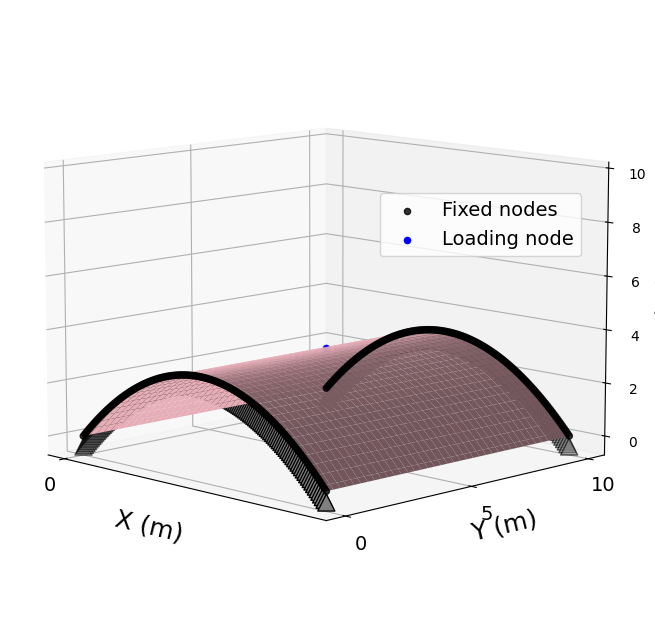

In [118]:
f(200)

73490.6849861145
-242.82602
DOF 242406
Number-Ele 40000


array([[    0,     1,   202,   201],
       [    1,     2,   203,   202],
       [    2,     3,   204,   203],
       ...,
       [40196, 40197, 40398, 40397],
       [40197, 40198, 40399, 40398],
       [40198, 40199, 40400, 40399]])

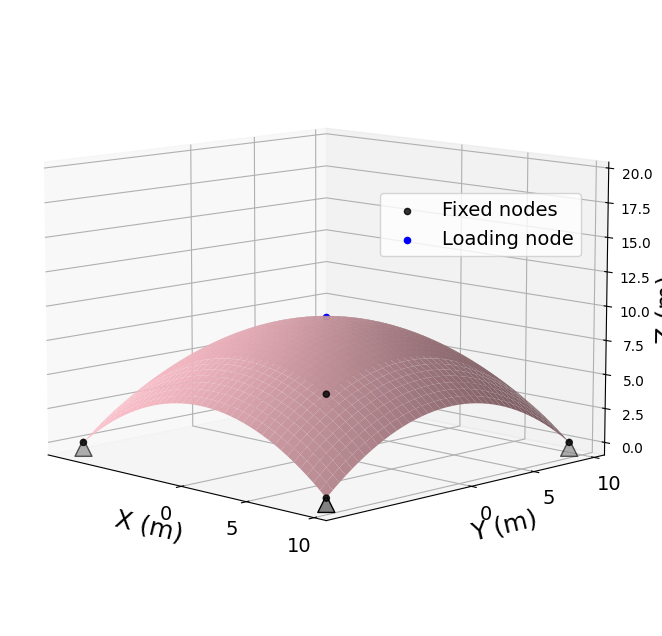

In [80]:
f(200)

99155.07388114929
-1780.3381
DOF 378006
Number-Ele 62500


array([[    0,     1,   252,   251],
       [    1,     2,   253,   252],
       [    2,     3,   254,   253],
       ...,
       [62746, 62747, 62998, 62997],
       [62747, 62748, 62999, 62998],
       [62748, 62749, 63000, 62999]])

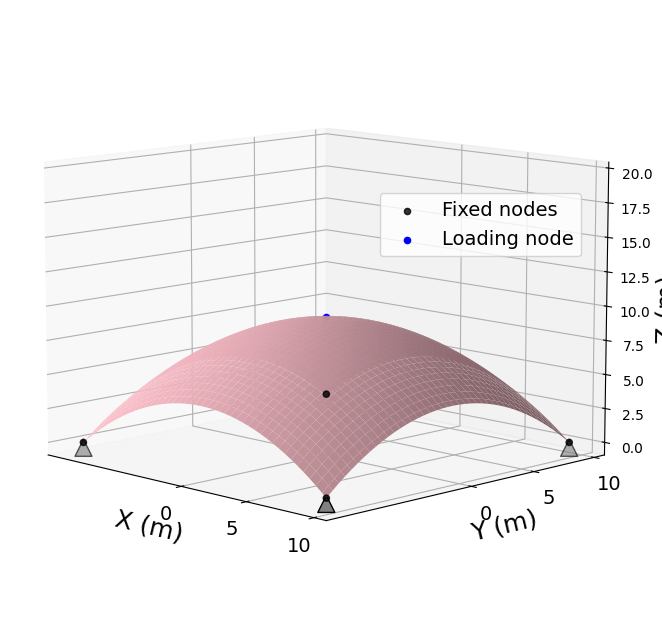

In [81]:
f(250)

In [259]:
'''col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)'''

NameError: name 'n_row' is not defined

In [ ]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()

In [ ]:
model.solve(which_solver='dense')
uz = model.u[design_nodes*6+2]
print(np.min(uz))

In [ ]:
model.solve(which_solver='sparse',enforce_scipy_sparse=True)
uz = model.u[design_nodes*6+2]
print(np.min(uz))

# Seems like "singular matrix" error of jax.spsolve happens sometimes

1. Happened: E = 24855578. -> min (u) = -0.025
2. Does not happen:  E = 2485557 ->  min (u) = -0.2501281588016551

Unit problem--> Stiffness matrix too large?

When 199 times 199 nodes, dense fails while sparse still works


Output nodal coordinates and connectivity

In [93]:
df1 = pd.DataFrame(cnct)
df1.to_csv('Cnct_shell.csv')
df2  = pd.DataFrame(crds)
df2.to_csv('Cnct_crds.csv')

# SAP 2000 results

Max displacement: -0.025368 m;
Strain energy:1231.128 KN*m